# Predictive model for differential diagnosis

In this notebook, our goal is to develop a model that can take in a patient's symptoms as an input and return a list of the top 3 possible classes (diseases) alongside confidence values for each class expressed as probabilities.


## Library and Data import

**Date:** 2021-07-12  

**Author:** "Rubanza Silver - Flexible Functions AI Lab"

In [1]:
#|include: false 

%pip install seaborn
%pip install fastkaggle
%pip install -Uqq fastbook
%pip install --upgrade pip
%pip install tqdm
%pip install kagglehub
#%pip install catboost
#%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
#%pip install xgboost
#%pip install lightgbm
#%pip install h2o
#%pip install polars
#%pip install -q -U autogluon.tabular
#%pip install autogluon
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#| code-fold: true
#| output: false
#| code-summary: "Library Import"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact
from fastai.imports import *
np.set_printoptions(linewidth=130)
from fastai.text.all import *
from pathlib import Path
import os
import warnings
import gc
import pickle
from joblib import dump, load

# ULMFiT approach

In traditional text transfer learning, We use a pre-trained model called a language model. The model we are also going to use in this example was initially trained on Wikipedia on the task of guessing the next word. We then fine-tuned this model for our disease classification task based on symptoms. We can then use this model for our task of disease classification.

But the Wikipedia English might differ from medical jargon, so to further improve our model. We can employ a technique shown in the [ULMFIT Paper](https://arxiv.org/abs/1801.06146) by Jeremy Howard and Sebastian Ruder. They take the above a step further by fitting the pre-trained model on medical corpus and then using that as a base for our classifier. They noticed that adding this step of training the pretrained model on the task specific corpus gives better result as the model also has better context of the final task.

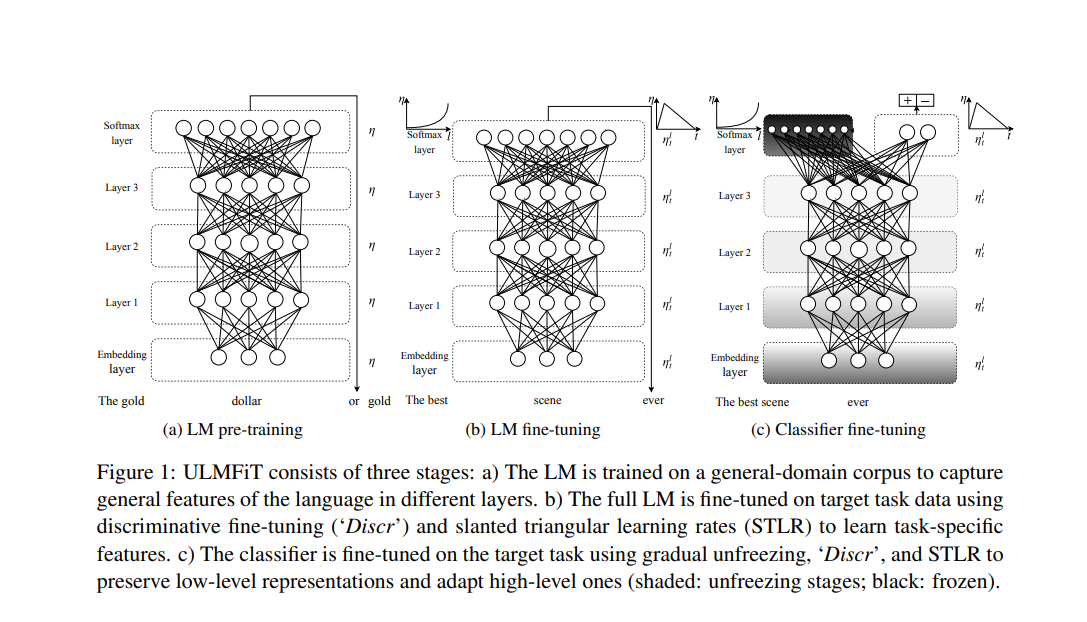

In [32]:
![An elephant](elephant.png){.lightbox}

/usr/bin/bash: -c: line 0: syntax error near unexpected token `('
/usr/bin/bash: -c: line 0: `[An elephant](elephant.png){.lightbox}'


In [3]:
import kagglehub

my_specific_path = "/data/" 

# Download latest version
path = kagglehub.dataset_download("rubanzasilva/symptoms-disease-no-id"),
output_path=my_specific_path

print("Path to dataset files:", path)

Path to dataset files: ('/teamspace/studios/this_studio/.cache/kagglehub/datasets/rubanzasilva/symptoms-disease-no-id/versions/1',)


In [5]:
path = Path('/teamspace/studios/this_studio/.cache/kagglehub/datasets/rubanzasilva/symptoms-disease-no-id/versions/1')
path

Path('/teamspace/studios/this_studio/.cache/kagglehub/datasets/rubanzasilva/symptoms-disease-no-id/versions/1')

In [5]:
!ls /teamspace/studios/this_studio/.cache/kagglehub/datasets/rubanzasilva/symptoms-disease-no-id/versions/1

models	symptom_disease_no_id_col.csv  symptom_no_id.csv


In [ ]:
#symptom_df = pd.read_csv(path_lm/'symptom_synth.csv',index_col=0)
symptom_df = pd.read_csv(path/'symptom_no_id.csv')
sd_df = pd.read_csv(path/'symptom_disease_no_id_col.csv')
symptom_df.head()

,text
0,"I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches."
1,"My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accompanied by a burning or stinging sensation."
2,"I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and throbbing, and it gets worse when I move my joints."
3,"There is a silver like dusting on my skin, especially on my lower back and scalp. This dusting is made up of small scales that flake off easily when I scratch them."
4,"My nails have small dents or pits in them, and they often feel inflammatory and tender to the touch. Even there are minor rashes on my arms."


In [7]:
symptom_df['text'].nunique(),sd_df['text'].nunique()

(1153, 1153)

## Finetuning a language model with my medical corpus

Below I define a DataLoader which is an extension of PyTorch's DataLoaders class, albeit with more functionality. This takes in our data, and prepares it as input for our model, passing it in batches etc.

The DataLoaders Object allows us to build data objects we can use for training without specifically changing the raw input data.

The dataloader then acts as input for our models. We also pass in valid_pct=0.2 which samples and uses 20% of our data for validation.

In [8]:
#dls_lm = TextDataLoaders.from_df(symptom_df, path=path, is_lm=True, valid_pct=0.2)
dls_lm = TextDataLoaders.from_df(symptom_df, path=path, is_lm=True,text_col='text', valid_pct=0.2)
#dls_lm = TextDataLoaders.from_folder(path=path_lm, is_lm=True, valid_pct=0.1)

We then use show_batch to have a look at some of our data.Since, we are guessing the next word in a sentence, you will notice that the targets have shifted one word to thr right in the *text_* column.

In [9]:
dls_lm.show_batch(max_n=5)

xxbos i have been experiencing a skin rash on my arms , legs , and torso for the past few weeks . xxmaj it is red , itchy , and covered in dry , xxunk patches . xxbos xxmaj i 've been having a lot of trouble going to the bathroom lately . xxmaj it 's been really painful and xxmaj i 've been experiencing pain in my anus . xxmaj my
there is a strong pain in my back and also behind my eyes . i have also noticed small red spots on my back and neck . xxbos i have a chronic dry cough . i have palpitations and my infections do n't appear to be getting better . i also have a painful throat xxunk , xxunk it does seem to go away . xxbos xxmaj recently , my muscles have
a lot of problems with my bowel motions recently . xxmaj it 's difficult to go , and it hurts when i do . xxmaj my anus is quite painful , and it has been bleeding whenever i go . xxmaj it 's excruciatingly painful , and xxmaj i 'm quite uneasy . xxbos xxmaj i 'm not in the mood to eat , and swallowing is difficult . i often have


From the above, we notice that the texts were processed and split into tokens. It adds some special tokens like xxbos to indicate the beginning of a text and xxmaj to indicate the next word was capitalised.

We then define a fastai [learner](https://docs.fast.ai/learner.html#learner), which is a fastai class that we can use to handle the training loop. It bundles the essential components needed for training together such as the data, model, the dataloaders, loss functions

We use the AWD LSTM architecture. We are also going to use accuracy and perplexity (the Exponential of the loss) as our metrics for this example. Furthermore, we also set a weight decay (wd) of 0.1 and apply mixed precision (.to_fp16()) to the learner, which speeds up training on GPU'S with tensor cores.


In [10]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

#### Phased Finetuning

A pre-trained model is one that has already been trained on a large dataset and has learnt general patterns and features in a dataset, which can then be used to fine-tune to a specific task. 

By default, the body of the model is frozen, meaning we won’t be updating the parameters of the body during training. For this case, only the head (first few layers) of the model will train.

In [11]:
#| error: false
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.302689,3.632804,0.342332,37.818718,00:02


As shown below, we can use the *learn.save* to save the state of our model to a file in learn.path/models/ named “filename.pth”. You can use learn.load('filename') to load the content of this file.

In [12]:
# Now save the model
learn.save('1epoch')

Path('/teamspace/studios/this_studio/.cache/kagglehub/datasets/rubanzasilva/symptoms-disease-no-id/versions/1/models/1epoch.pth')

In [13]:
#| error: false
learn = learn.load('1epoch')

After training the head of the model, we unfreeze the rest of the body and finetune it alongside the head, except for our final layer, which converts activations into probabilities of picking each token in our vocabulary.

In [14]:
#| error: false
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.587642,2.953272,0.398495,19.168573,00:01
1,3.262225,2.604236,0.434433,13.520896,00:01
2,3.005299,2.404017,0.464337,11.067551,00:01
3,2.831740,2.315215,0.482234,10.127099,00:01
4,2.708957,2.295945,0.486777,9.933821,00:01


The model not including the final layers is called an encoder. We use fastai's *save_encoder* to save it as shown below.

In [15]:
#| code-fold: show
#| output: false
#| code-summary: "Save the model"
# Now save the model
learn.save_encoder('finetuned')

Now, that our model has been trained to guess or generate the next word in a sentence, we can use it to create or generate new user inputs that start with the below user input text.

In [16]:
#| output: false
#| error: false
TEXT = "I have running nose, stomach and joint pains"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [17]:
print("\n".join(preds))

i have running nose , stomach and joint pains . My skin is red , and my skin has been really weird . I radiates a lot of diarrhea and suddenly developed a rash on my face . I mucous . It 's been
i have running nose , stomach and joint pains . My eyes become yellow and I brain sweating . I 've had a high fever , a high fever , and intense fever . I 've been experiencing a lot of back pain


## Training a text classifier

We now gather and pass in data to train our text classifier.

In [18]:
#symptom_df = pd.read_csv(path_lm/'symptom_synth.csv',index_col=0)
#sd_df = pd.read_csv(path_lm/'symptom_disease_no_id_col.csv')
sd_df.head()

,label,text
0,Psoriasis,"I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches."
1,Psoriasis,"My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accompanied by a burning or stinging sensation."
2,Psoriasis,"I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and throbbing, and it gets worse when I move my joints."
3,Psoriasis,"There is a silver like dusting on my skin, especially on my lower back and scalp. This dusting is made up of small scales that flake off easily when I scratch them."
4,Psoriasis,"My nails have small dents or pits in them, and they often feel inflammatory and tender to the touch. Even there are minor rashes on my arms."


In [19]:
# Check for NaN values in the label column
print(sd_df['label'].isna().sum())

# If there are NaNs, you can drop those rows
#df = df.dropna(subset=['label'])

0


In [20]:
#| output: false
#| error: false
#dls_clas = TextDataLoaders.from_df(sd_df, path=path,valid='test', text_vocab=dls_lm.vocab)
dls_clas = TextDataLoaders.from_df(sd_df, path=path,valid='test',text_col='text',label_col='label', text_vocab=dls_lm.vocab)

Passing in *text_vocab=dls_lm.vocab* passes in our previously defined vocabulary to our classifier. 

> To quote the fastai documentation, we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won’t make any sense.

When you train a language model, it learns to associate specific patterns of numbers (weights) with specific tokens (words or subwords) in your vocabulary. 

Each token is assigned a unique index in the vocabulary, and the model's internal representations (the weights in the embedding layers and beyond) are organised according to these indices.

Think of it like a dictionary where each word has a specific page number. The model learns that information about "good" is on page 382, information about "movie" is on page 1593, and so on. These "page numbers" (indices) must remain consistent for the weights to make sense.

If you were to use a different vocabulary when creating your classifier:
.The token "good" might now be on page 746 instead of 382
.The weights the model learned during language model training were specifically tied to the old index (382)

Now when the classifier sees "good" and looks up page 746, it finds weights that were meant for some completely different word

>This mismatch would render the carefully fine-tuned language model weights essentially random from the perspective of the classifier.

In [21]:
#| error: false
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

We then define our text classifier as shown above. Before training it, we load in the previous encoder.

In [22]:
#| include: false
#from pathlib import Path
#learn.path = Path('/kaggle/working')

In [23]:
#| error: false
learn = learn.load_encoder('finetuned')

#### Discriminative Learning Rates & Gradual Unfreezing

**Discriminative learning** rates means using different learning rates for different layers of the model. 

For example, earlier layers (closer to the input) might get smaller learning rates, while the later layers (closer to the output) get larger learning rates.

**Gradual unfreezing** is a technique where layers of the model are unfrozen (made trainable) incrementally during fine-tuning. 
Instead of unfreezing all layers at once, you start by unfreezing only the topmost layers (closest to the output) and train them first.

Unlike computer vision applications where we unfreeze the model at once, gradual unfreezing has been shown to improve performance for NLP models.




In [24]:
len(dls_lm.vocab)

944

In [25]:
#| error: false
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.321553,2.321026,0.475000,00:01


In [26]:
#| error: false
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.472523,1.618218,0.650000,00:01


In [27]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.113426,1.222948,0.737500,00:02
1,1.053115,0.926983,0.804167,00:02
2,0.977086,0.776898,0.816667,00:02
3,0.886906,0.666213,0.845833,00:02
4,0.796531,0.585332,0.862500,00:02
5,0.705722,0.525745,0.875000,00:02
6,0.627141,0.489742,0.887500,00:02
7,0.554622,0.462450,0.895833,00:02
8,0.501509,0.441437,0.895833,00:02
9,0.457569,0.432032,0.900000,00:02


In [28]:
learn.predict("I am having a running stomach, fever, general body weakness and have been getting bitten by mosquitoes often")

('Typhoid',
 tensor(16),
 tensor([0.0032, 0.0312, 0.0315, 0.0267, 0.0032, 0.0082, 0.0466, 0.0522, 0.0044,
         0.1089, 0.0058, 0.0142, 0.0568, 0.1298, 0.0267, 0.0030, 0.3377, 0.0080,
         0.0047, 0.0078, 0.0069, 0.0212, 0.0460, 0.0152]))

In [29]:
def get_top_3_predictions(text, learn):
    # Get prediction and probabilities
    _, _, probs = learn.predict(text)
    
    # Get the disease labels vocabulary (second list in vocab)
    disease_vocab = learn.dls.vocab[1]  # Access the disease labels
    
    # Get number of classes
    n_classes = len(disease_vocab)
    
    # Get indices of top 3 (or fewer) probabilities
    n_preds = min(3, n_classes)
    top_k_indices = probs.argsort(descending=True)[:n_preds]
    
    # Get the actual labels and their probabilities
    predictions = []
    for idx in top_k_indices:
        label = disease_vocab[int(idx)]
        probability = float(probs[idx])
        predictions.append((label, probability))
    
    return predictions

# Function to format and display the predictions nicely
def display_predictions(predictions):
    for i, (disease, prob) in enumerate(predictions, 1):
        print(f"{i}. {disease}: {prob:.3f}")

In [30]:
test_text = "I am having a running stomach, fever, general body weakness and have been getting bitten by mosquitoes often"
predictions = get_top_3_predictions(test_text, learn)
print("\nTop 3 Predictions:")
display_predictions(predictions)


Top 3 Predictions:
1. Typhoid: 0.338
2. Migraine: 0.130
3. Hypertension: 0.109


In [8]:
#| code-fold: true
#| code-summary: "Click to see full code in one cell"
#| error: false
#| echo false

#path = Path('/kaggle/input/symptoms-disease-no-id')
#symptom_df = pd.read_csv(path_lm/'symptom_synth.csv',index_col=0)
symptom_df = pd.read_csv(path/'symptom_no_id.csv')
sd_df = pd.read_csv(path/'symptom_disease_no_id_col.csv')
dls_lm = TextDataLoaders.from_df(symptom_df, path=path,text_col='text', is_lm=True, valid_pct=0.2)
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()
learn.fit_one_cycle(1, 1e-2)
# Create a directory to save the model
#os.makedirs('/kaggle/working/models', exist_ok=True)
# Set the model directory for the learner
#learn.model_dir = '/kaggle/working/models'
# Now save the model
learn.save('1epoch')
learn = learn.load('1epoch')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)
# Now save the model
learn.save_encoder('finetuned')


#finetuning the classifier
dls_clas = TextDataLoaders.from_df(sd_df, path=path,valid='test',text_col='text',label_col='label', text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
#learn.path = Path('/kaggle/working')
learn = learn.load_encoder('finetuned')
learn.fit_one_cycle(1, 2e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn.predict("I am having a running stomach, fever, general body weakness and have been getting bitten by mosquitoes often")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.340536,3.536887,0.344256,34.359787,00:18


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.587240,2.898959,0.392433,18.155239,00:19
1,3.288267,2.516588,0.450521,12.386265,00:19
2,3.066310,2.299803,0.494719,9.972213,00:18
3,2.888978,2.201053,0.501374,9.034521,00:18
4,2.773767,2.187530,0.507089,8.913166,00:18


epoch,train_loss,valid_loss,accuracy,time
0,2.216417,2.359561,0.458333,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.413656,1.494158,0.720833,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.988190,0.987575,0.779167,00:22
1,0.896933,0.754394,0.816667,00:21


('Malaria',
 tensor(12),
 tensor([0.0347, 0.0418, 0.0864, 0.0518, 0.0039, 0.1057, 0.0317, 0.0286, 0.0043,
         0.0742, 0.0085, 0.0355, 0.1145, 0.0264, 0.0581, 0.0082, 0.0397, 0.0056,
         0.0353, 0.0390, 0.0331, 0.0328, 0.0419, 0.0582]))

In [9]:
def get_top_3_predictions(texts, learn):
    """
    Get top 3 predictions for a single text or list of texts
    
    Args:
        texts: Either a single string or a list of strings
        learn: A trained fastai learner for text classification
        
    Returns:
        For a single text: List of (label, probability) tuples
        For multiple texts: List of lists of (label, probability) tuples
    """
    # Handle both single text and list of texts
    is_single = isinstance(texts, str)
    if is_single:
        texts = [texts]
    
    disease_vocab = learn.dls.vocab[1]
    n_classes = len(disease_vocab)
    
    # Try to use DataLoader for batch prediction if model supports it
    try:
        # This is more efficient but might not work with all models
        preds = learn.get_preds(dl=learn.dls.test_dl(texts))
        probs_list = preds[0]  # Tensor of shape [batch_size, n_classes]
        
        all_predictions = []
        for probs in probs_list:
            n_preds = min(3, n_classes)
            top_k_indices = probs.argsort(descending=True)[:n_preds]
            
            predictions = []
            for idx in top_k_indices:
                label = disease_vocab[int(idx)]
                probability = float(probs[idx])
                predictions.append((label, probability))
            
            all_predictions.append(predictions)
    
    except Exception:
        # Fall back to individual prediction if batch method fails
        all_predictions = []
        for text in texts:
            _, _, probs = learn.predict(text)
            
            n_preds = min(3, n_classes)
            top_k_indices = probs.argsort(descending=True)[:n_preds]
            
            predictions = []
            for idx in top_k_indices:
                label = disease_vocab[int(idx)]
                probability = float(probs[idx])
                predictions.append((label, probability))
            
            all_predictions.append(predictions)
    
    return all_predictions[0] if is_single else all_predictions


def display_predictions(predictions, texts=None):
    """
    Display formatted predictions
    
    Args:
        predictions: Either a list of (label, prob) tuples or a list of such lists
        texts: Optional list of input texts to display with predictions
    """
    # If predictions is a list of (label, prob) tuples (single text case)
    if isinstance(predictions[0], tuple):
        for i, (disease, prob) in enumerate(predictions, 1):
            print(f"{i}. {disease}: {prob:.3f}")
    # If predictions is a list of lists (batch case)
    else:
        for i, preds in enumerate(predictions):
            if texts:
                print(f"\nText: {texts[i][:50]}...")
            else:
                print(f"\nSample #{i+1}:")
            for j, (disease, prob) in enumerate(preds, 1):
                print(f"  {j}. {disease}: {prob:.3f}")


In [10]:
# Assuming 'learn' is your trained FastAI model

# Example 1: Single input
single_text = "Patient presents with persistent cough, fever of 101°F for 5 days, and fatigue."
single_result = get_top_3_predictions(single_text, learn)

print("SINGLE TEXT PREDICTION:")
print(f"Input: {single_text}")
print("Top 3 predictions:")
display_predictions(single_result)


# Example 2: Batch input (small batch)
batch_texts = [
    "Patient presents with persistent cough, fever of 101°F for 5 days, and fatigue.",
    "7-year-old with red, itchy rash on face and arms, started 2 days after camping trip.",
    "Adult male with sudden onset of severe headache, described as 'worst headache of my life'.",
    "Patient reports joint pain in fingers and wrists, worse in the morning, accompanied by stiffness."
]
batch_results = get_top_3_predictions(batch_texts, learn)

print("\nBATCH PREDICTION EXAMPLE:")
display_predictions(batch_results, batch_texts)


# Example 3: Processing a medium-sized dataset
medium_dataset = [
    f"Patient {i}: Symptoms include {symptom}" for i, symptom in enumerate([
        "fever and sore throat",
        "chest pain radiating to left arm",
        "swollen lymph nodes and night sweats",
        "difficulty breathing and wheezing",
        "abdominal pain and vomiting",
        "frequent urination and excessive thirst",
        "joint pain and morning stiffness",
        "persistent headache and blurred vision",
        "unexplained weight loss and fatigue",
        "skin rash and itching"
    ] * 3)  # Repeat symptoms to create 30 samples
]

print("\nPROCESSING MEDIUM DATASET:")
medium_results = get_top_3_predictions(medium_dataset, learn)
# Display first 3 results only for brevity
print("First 3 results from medium dataset:")
display_predictions(medium_results[:3], medium_dataset[:3])


# Example 4: Working with DataFrame data
# This example demonstrates how you might use the function with pandas DataFrame
import pandas as pd

# Create a sample DataFrame
df = pd.DataFrame({
    'patient_id': range(1001, 1006),
    'age': [45, 12, 67, 32, 54],
    'gender': ['M', 'F', 'M', 'F', 'M'],
    'symptoms': [
        "Persistent dry cough and fever for 3 days",
        "Skin rash with small fluid-filled blisters, mild fever",
        "Shortness of breath, chest tightness, wheezing when exercising",
        "Severe migraine, sensitivity to light, nausea",
        "Pain and swelling in the right knee, difficulty walking"
    ]
})

print("\nPROCESSING DATAFRAME:")
print("Sample DataFrame:")
print(df[['patient_id', 'symptoms']].head())

# Process the symptoms column
df_results = get_top_3_predictions(df['symptoms'].tolist(), learn)

# Add predictions back to the DataFrame
df['top_prediction'] = [pred[0][0] for pred in df_results]  # First prediction label
df['confidence'] = [pred[0][1] for pred in df_results]      # First prediction probability

print("\nDataFrame with predictions:")
print(df[['patient_id', 'symptoms', 'top_prediction', 'confidence']])

SINGLE TEXT PREDICTION:
Input: Patient presents with persistent cough, fever of 101°F for 5 days, and fatigue.
Top 3 predictions:
1. Migraine: 0.236
2. Malaria: 0.161
3. Pneumonia: 0.141



BATCH PREDICTION EXAMPLE:

Text: Patient presents with persistent cough, fever of 1...
  1. Migraine: 0.236
  2. Malaria: 0.161
  3. Pneumonia: 0.141

Text: 7-year-old with red, itchy rash on face and arms, ...
  1. Impetigo: 0.670
  2. Psoriasis: 0.082
  3. Fungal infection: 0.041

Text: Adult male with sudden onset of severe headache, d...
  1. Dengue: 0.341
  2. Pneumonia: 0.108
  3. Malaria: 0.089

Text: Patient reports joint pain in fingers and wrists, ...
  1. Dengue: 0.264
  2. Psoriasis: 0.197
  3. Varicose Veins: 0.109

PROCESSING MEDIUM DATASET:


First 3 results from medium dataset:

Text: Patient 0: Symptoms include fever and sore throat...
  1. urinary tract infection: 0.128
  2. Common Cold: 0.113
  3. Jaundice: 0.093

Text: Patient 1: Symptoms include chest pain radiating t...
  1. Jaundice: 0.210
  2. Malaria: 0.121
  3. Hypertension: 0.071

Text: Patient 2: Symptoms include swollen lymph nodes an...
  1. Impetigo: 0.245
  2. urinary tract infection: 0.116
  3. Jaundice: 0.073

PROCESSING DATAFRAME:
Sample DataFrame:
   patient_id                                                        symptoms
0        1001                       Persistent dry cough and fever for 3 days
1        1002          Skin rash with small fluid-filled blisters, mild fever
2        1003  Shortness of breath, chest tightness, wheezing when exercising
3        1004                   Severe migraine, sensitivity to light, nausea
4        1005         Pain and swelling in the right knee, difficulty walking



DataFrame with predictions:
   patient_id                                                        symptoms  \
0        1001                       Persistent dry cough and fever for 3 days   
1        1002          Skin rash with small fluid-filled blisters, mild fever   
2        1003  Shortness of breath, chest tightness, wheezing when exercising   
3        1004                   Severe migraine, sensitivity to light, nausea   
4        1005         Pain and swelling in the right knee, difficulty walking   

     top_prediction  confidence  
0  Bronchial Asthma    0.170556  
1          Impetigo    0.312419  
2         Pneumonia    0.266389  
3           Malaria    0.158541  
4         Arthritis    0.197566  


# References

[Fastai Documentation - Text Transfer Learning](https://docs.fast.ai/tutorial.text.html#the-ulmfit-approach)

The dataset for this competition was gotten from [here](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease)

This notebook which uploaded to github was published using [nbsanity](https://www.answer.ai/posts/2024-12-13-nbsanity.html)

## Next Steps

* Using clinical guidelines as a medical corpus source.

* Implementing a newer architecture, e.g., replacing AWD_LSTM with transformers.

* Try out a RAG implementation 

* Finetune our own medical model

* Adding reasoning

* Building a UI
